# Experiment 2.1.Sports1M+C3D
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Calculating accuracy for finiding similar video and dissimilar videos

In [1]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Using Theano backend.


Backend ok


In [2]:
## Imports
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.models import Sequential
import random
import numpy as np
from PIL import Image
from os import listdir
from scipy.ndimage import imread
import os
from sklearn import svm
import pouring_dataset as pour
from keras.utils import np_utils
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from sklearn.utils import shuffle


# Custom scripts
import lscript as lsp
import modelling as md
import dataset as dset
from read_activations import *

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
height=112 
width=112 
channel=3
nb_class=3
cluster_length=8
strides=9
total_frames_in_seq=8
time_step=8
num_clusters= int( (total_frames_in_seq-cluster_length) / strides) + 1
feature_size=8192 #4608 #8192   #16384  #487
batch_size=32
memory_batch_size=266
nb_classes=2
crop_size=112
memory_batch_size_test=170


#### Dataset 

In [4]:
sample_images, sample_labels, next_batch_start, _ = pour.read_vid_and_label('./Pouring and Dissimilar Dataset/train.list',memory_batch_size,0,cluster_length,112,normalisation=True)

Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_clear1_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_clear1_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_clear_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_clear_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_white0_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_white0_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_white1_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_white1_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_white_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearodwalla_to_white_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/clearsoda_to_white

Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_clear_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white0_fake_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white0_fake_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white0_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white0_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white1_fake_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white1_fake_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white1_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white1_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white2_fake_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/crystal_to_white2_fake_view1...
Loading /nobackup/leopauly/Pourin

Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_clear_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white0_fake_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white0_fake_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white0_real_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white0_real_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white1_fake_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white1_fake_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white3_fake_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white3_fake_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white4_fake_view0...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white4_fake_view1...
Loading /nobackup/leopauly/Pouring_Dataset_Images/train/pom_to_white5_fake_vi

In [5]:
print(sample_images.shape)
print(sample_labels.shape)
print('labels',sample_labels)
print(next_batch_start)

(266, 8, 112, 112, 3)
(266,)
labels [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 23

label:1
Video_seq shape: (266, 8, 112, 112, 3) Label shape (266,)


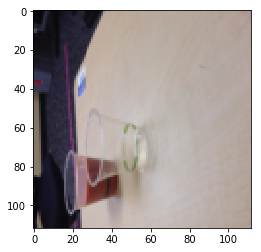

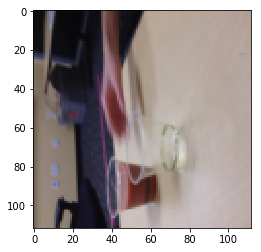

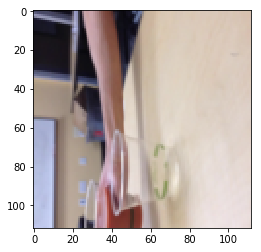

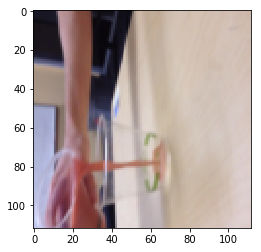

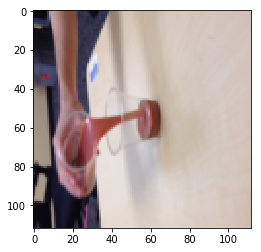

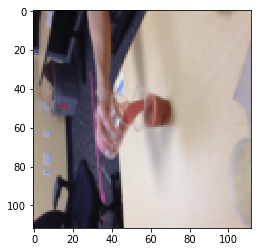

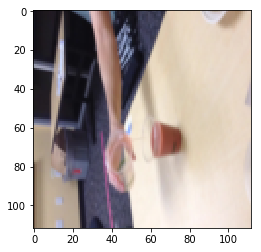

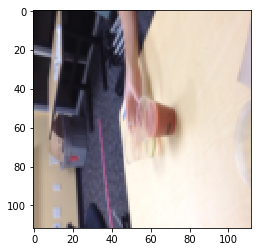

In [6]:
item_num=1
lsp.view_video_seq(sample_images,sample_labels,cluster_length,item_num)

#### Loading model 

In [7]:
model=md.custom_modelC3D_theano(cluster_length)

/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_B_viewpoint_invariance_C3D+newloss/modelling.py:176: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(3, 8, 112..., trainable=False, strides=(1, 1, 1), padding="same")`
  trainable=False))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_B_viewpoint_invariance_C3D+newloss/modelling.py:177: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  model.add(MaxPooling3D(pool_size=(1, 2, 2),strides=(1, 2, 2),border_mode='valid',name='pool1'))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_B_viewpoint_invariance_C3D+newloss/modelling.py:181: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", trainable=False, strides=(1, 1, 1), paddin

KeyError: "Can't open attribute (Can't locate attribute: 'layer_names')"

#### Training SVM 

##### Converting videos into feature vectors :

In [ ]:
train_sim_images, train_labels, next_batch_start, _ = pour. read_vid_and_label('Pouring and Dissimilar Dataset/train.list',memory_batch_size,0,cluster_length,crop_size,normalisation=True)

In [ ]:
print('Total number of similar videos:', train_sim_images.shape)

In [ ]:
def extract_video_feature_vector(vid):
    #print(vid.shape)
    t=vid.reshape(1,channel,cluster_length,height,width)
    t_f=np.array(get_activations(model,t,print_shape_only=True,layer_name='flatten'))
    #print(t_f.shape)
    return t_f

In [ ]:
iter=0
f_similar=np.empty([int(memory_batch_size/2),feature_size*2])
for i in range(0,memory_batch_size,2):
    f_1=extract_video_feature_vector(train_sim_images[i])
    f_2=extract_video_feature_vector(train_sim_images[i+1])
    f_similar[iter]=np.append(f_1,f_2)
    iter=iter+1
print('training feature size:', f_similar.shape)

In [ ]:
train_dis_images, train_labels, next_batch_start, _ = pour.read_vid_and_label('Pouring and Dissimilar Dataset/train_dissimilar.list',memory_batch_size,0,cluster_length,crop_size,normalisation=True)

In [ ]:
print('Total number of dissimilar videos:', train_dis_images.shape)

In [ ]:
iter=0
f_dissimilar=np.empty([int(memory_batch_size/2),feature_size*2])
for i in range(0,memory_batch_size,2):
    f_1=extract_video_feature_vector(train_dis_images[i])
    f_2=extract_video_feature_vector(train_dis_images[i+1])
    f_dissimilar[iter]=np.append(f_1,f_2)
    iter=iter+1
print('training feature size:', f_dissimilar.shape)

In [ ]:
features_train=np.concatenate((f_similar,f_dissimilar),axis=0)
print('training feature size:', features_train.shape)

##### Creating labels:

In [ ]:
y_1_train=np.zeros(133)
y_2_train=np.ones(133)
y_train=np.append(y_1_train,y_2_train)
#y_train = np_utils.to_categorical(y_train, nb_classes)

In [ ]:
print('label size train',y_train.shape)
print(y_train[132])

##### Training:

In [ ]:
features_train, y_train = shuffle(features_train, y_train, random_state=0)
classifier= svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
classifier.fit(features_train, y_train)  

#### Testing similarity classification accuracy 

In [ ]:
test_sim_images, test_labels, next_batch_start, _ = pour. read_vid_and_label('Pouring and Dissimilar Dataset/test.list',memory_batch_size,0,cluster_length,crop_size,normalisation=True)

print('Total number of similar videos:', test_sim_images.shape)

iter=0
f_similar=np.empty([int(memory_batch_size_test/2),feature_size*2])
for i in range(0,memory_batch_size_test,2):
    f_1=extract_video_feature_vector(test_sim_images[i])
    f_2=extract_video_feature_vector(test_sim_images[i+1])
    f_similar[iter]=np.append(f_1,f_2)
    iter=iter+1
print('testing feature size:', f_similar.shape)

test_dis_images, test_labels, next_batch_start, _ = pour.read_vid_and_label('Pouring and Dissimilar Dataset/test_dissimilar.list',memory_batch_size,0,cluster_length,crop_size,normalisation=True)

print('Total number of dissimilar videos:', test_dis_images.shape)

iter=0
f_dissimilar=np.empty([int(memory_batch_size_test/2),feature_size*2])
for i in range(0,memory_batch_size_test,2):
    f_1=extract_video_feature_vector(test_dis_images[i])
    f_2=extract_video_feature_vector(test_dis_images[i+1])
    f_dissimilar[iter]=np.append(f_1,f_2)
    iter=iter+1
print('testing feature size:', f_dissimilar.shape)

features_test=np.concatenate((f_similar,f_dissimilar),axis=0)
print('testing feature size:', features_test.shape)


In [ ]:
y_1_test=np.zeros(85)
y_2_test=np.ones(85)
y_test=np.append(y_1_test,y_2_test)
#y_test = np_utils.to_categorical(y_test, nb_classes)
print('label size test',y_test.shape)

In [ ]:
cross_val_score(classifier, features_test, y_test, scoring='accuracy') 